# Benchmarking the Recovery of Known Drug Targets from L1000 CRISPR KO Data: NR0B1 Version

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import requests
import urllib.request
import json
import time
import scipy.stats as ss
from maayanlab_bioinformatics.normalization.filter import filter_by_expr
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction
from maayanlab_bioinformatics.dge.limma_voom import limma_voom_differential_expression
from maayanlab_bioinformatics.enrichment import enrich_crisp
from math import log2
from IPython.display import display, Markdown
from random import sample
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import seaborn as sns
from os.path import exists
from scipy.stats import ttest_ind, ranksums
import h5py

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# Set KO gene
ko_gene = 'NR0B1'

# Set working directory
l1000_data_dir = '../L1000_data'

In [4]:
try: 
    expr_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv", sep='\t', index_col=0)
except: 
    l1000_data_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_data.tsv", sep='\t')

    l1000_data_list = []
    l1000_meta_list = []
    for row in l1000_data_df.itertuples(): 
        try:
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns:
            l1000_meta_list.append([col] + l1000_data_df.loc[row.Index].tolist())
        l1000_data_list.append(temp_df)
    expr_df = pd.concat(l1000_data_list, axis=1)

expr_df.head()

,XPR032_A375.311_96H_X1_B38:N14,XPR032_A375.311_96H_X2_B38:N14,XPR032_A375.311_96H_X3_B38:N14,XPR032_A375.311_96H_X1_B38:P20,XPR032_A375.311_96H_X3_B38:P20,XPR032_A549.311_96H_X1_B38:N14,XPR032_A549.311_96H_X2_B38:N14,XPR032_A549.311_96H_X3_B38:N14,XPR032_A549.311_96H_X1_B38:P20,XPR032_A549.311_96H_X2_B38:P20,...,XPR032_U251MG.311_96H_X2_B38:N14,XPR032_U251MG.311_96H_X3_B38:N14,XPR032_U251MG.311_96H_X1_B38:P20,XPR032_U251MG.311_96H_X2_B38:P20,XPR032_U251MG.311_96H_X3_B38:P20,XPR032_YAPC.311_96H_X4.L2_B41:N14,XPR032_YAPC.311_96H_X5.L2_B41:N14,XPR032_YAPC.311_96H_X6.L2_B41:N14,XPR032_YAPC.311_96H_X4.L2_B41:P20,XPR032_YAPC.311_96H_X6.L2_B41:P20
symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,5.255000,5.089600,5.427650,5.166525,5.239900,5.506400,5.4724,5.4069,5.7438,5.462400,...,5.63815,5.825700,6.23110,5.26800,5.916700,6.679475,6.938175,5.278950,7.19605,7.62890
PAX8,4.913075,5.132925,5.074600,4.669800,5.265650,4.016100,4.6268,4.2078,4.2377,4.310450,...,4.42210,4.625200,4.62415,4.53150,5.175500,4.408500,4.002800,4.260275,4.15570,3.35210
GUCA1A,5.193900,5.247600,4.621200,5.694850,5.050300,4.331350,4.3682,4.2829,4.3346,4.207350,...,4.98960,4.619000,4.86720,4.67185,4.904350,5.476200,5.236925,5.535125,5.46450,5.54065
EPHB3,5.674850,6.362250,6.259725,5.560650,6.506450,6.481000,6.4755,6.9908,6.4902,6.621600,...,7.15630,7.442451,7.25270,6.36430,7.246000,7.240800,7.576700,7.964250,7.88650,7.55025
ESRRA,7.840600,7.572600,7.368150,7.538750,7.622751,7.349851,7.5800,7.1017,7.1989,7.012701,...,6.22650,6.905600,6.75130,6.59240,7.017099,8.261250,8.548100,7.938550,8.24955,8.39360


In [5]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv"): 
    expr_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_CRISPRKO_fulldata.tsv' already exists!


In [6]:
try: 
    meta_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv", sep='\t', index_col=0)
except:
    meta_df = pd.DataFrame(l1000_meta_list, columns=['id'] + l1000_data_df.columns.tolist()).set_index('id')
if 'batch' not in meta_df.columns:
    meta_df['batch'] = meta_df.index.map(lambda x: '_'.join(x.split('_')[:3]))
meta_df.head()

,tissue,disease,cell_line,pert_name,pert_time,pert_type,data_level,creation_time,persistent_id,pert_dose,batch
id,,,,,,,,,,,
XPR032_A375.311_96H_X1_B38:N14,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X2_B38:N14,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X3_B38:N14,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X1_B38:P20,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X3_B38:P20,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H


In [7]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv"): 
    meta_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_CRISPRKO_metadata.tsv' already exists!


In [8]:
batches = meta_df['batch'].unique()
len(batches)

9

## Load in Control Data

In [9]:
ctrl_data_df = pd.read_csv(f"{l1000_data_dir}/L1000_Controls.tsv", sep='\t')
ctrl_data_df = ctrl_data_df[ctrl_data_df['batch'].isin(batches)]
set(batches).difference(ctrl_data_df['batch'])

set()

In [10]:
ctrl_data_df.head()

,local_id,persistent_id,batch
10777,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_D10_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10778,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_E14_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10779,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_F21_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10780,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_G09_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10781,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_H16_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H


In [11]:
try: 
    ctrl_expr_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv", sep='\t', index_col=0)
    ctrl_meta_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv", sep='\t', index_col=0)
except:
    ctrl_data_list = []
    ctrl_meta_list = []
    for row in ctrl_data_df.itertuples():
        try: 
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns: 
            ctrl_meta_list.append([col, row.batch])
        ctrl_data_list.append(temp_df)

    ctrl_expr_df = pd.concat(ctrl_data_list, axis=1)
    ctrl_meta_df = pd.DataFrame(ctrl_meta_list, columns=['id', 'batch']).set_index('id')

In [12]:
ctrl_expr_df.head()

,XPR032_A375.311_96H_X1_B38:D10,XPR032_A375.311_96H_X2_B38:D10,XPR032_A375.311_96H_X3_B38:D10,XPR032_A375.311_96H_X1_B38:E14,XPR032_A375.311_96H_X2_B38:E14,XPR032_A375.311_96H_X3_B38:E14,XPR032_A375.311_96H_X1_B38:F21,XPR032_A375.311_96H_X2_B38:F21,XPR032_A375.311_96H_X3_B38:F21,XPR032_A375.311_96H_X1_B38:G09,...,XPR032_YAPC.311_96H_X6.L2_B41:I09,XPR032_YAPC.311_96H_X4.L2_B41:K10,XPR032_YAPC.311_96H_X5.L2_B41:K10,XPR032_YAPC.311_96H_X6.L2_B41:K10,XPR032_YAPC.311_96H_X4.L2_B41:K20,XPR032_YAPC.311_96H_X5.L2_B41:K20,XPR032_YAPC.311_96H_X6.L2_B41:K20,XPR032_YAPC.311_96H_X4.L2_B41:P03,XPR032_YAPC.311_96H_X5.L2_B41:P03,XPR032_YAPC.311_96H_X6.L2_B41:P03
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,8.064151,9.469100,7.601850,8.033700,9.220400,8.24655,8.894925,8.72050,9.17865,8.68495,...,11.370251,10.716150,10.178425,11.328951,9.41990,11.02845,12.07100,11.243151,9.276251,9.758101
ADA,6.507850,6.016400,7.335375,6.141600,5.903550,6.85880,6.393500,6.74075,6.35025,5.83335,...,4.890375,5.205100,3.744300,5.539550,5.21020,4.89420,4.83905,4.656200,4.270800,5.249350
CDH2,4.857850,4.623050,5.011100,4.752725,4.761450,4.68530,5.200500,4.61915,4.61665,4.86035,...,4.382100,4.921475,4.550850,4.611150,4.30870,4.04470,4.89275,5.437850,4.703550,5.628650
AKT3,4.182400,1.805000,4.125150,3.381000,3.420925,4.00585,4.777750,4.22330,6.42225,2.92995,...,0.000000,1.254300,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
MED6,5.369700,6.277175,7.007350,6.533900,6.349325,6.65425,5.729750,6.16220,6.22880,6.02475,...,6.200250,6.642900,5.949200,7.149099,6.65355,6.47650,6.49045,7.638025,6.261400,7.256250


In [13]:
ctrl_meta_df.head()

,batch
id,
XPR032_A375.311_96H_X1_B38:D10,XPR032_A375.311_96H
XPR032_A375.311_96H_X2_B38:D10,XPR032_A375.311_96H
XPR032_A375.311_96H_X3_B38:D10,XPR032_A375.311_96H
XPR032_A375.311_96H_X1_B38:E14,XPR032_A375.311_96H
XPR032_A375.311_96H_X2_B38:E14,XPR032_A375.311_96H


In [14]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv"): 
    ctrl_expr_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_Controls_fulldata.tsv' already exists!


In [15]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv"): 
    ctrl_meta_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_Controls_metadata.tsv' already exists!


## Process Data

### Combine data and remove duplicate genes

In [16]:
combined_expr_df = pd.concat([
    expr_df.groupby(expr_df.index).mean(), 
    ctrl_expr_df.groupby(ctrl_expr_df.index).mean()
], axis=1)
combined_expr_df.head()

,XPR032_A375.311_96H_X1_B38:N14,XPR032_A375.311_96H_X2_B38:N14,XPR032_A375.311_96H_X3_B38:N14,XPR032_A375.311_96H_X1_B38:P20,XPR032_A375.311_96H_X3_B38:P20,XPR032_A549.311_96H_X1_B38:N14,XPR032_A549.311_96H_X2_B38:N14,XPR032_A549.311_96H_X3_B38:N14,XPR032_A549.311_96H_X1_B38:P20,XPR032_A549.311_96H_X2_B38:P20,...,XPR032_YAPC.311_96H_X6.L2_B41:I09,XPR032_YAPC.311_96H_X4.L2_B41:K10,XPR032_YAPC.311_96H_X5.L2_B41:K10,XPR032_YAPC.311_96H_X6.L2_B41:K10,XPR032_YAPC.311_96H_X4.L2_B41:K20,XPR032_YAPC.311_96H_X5.L2_B41:K20,XPR032_YAPC.311_96H_X6.L2_B41:K20,XPR032_YAPC.311_96H_X4.L2_B41:P03,XPR032_YAPC.311_96H_X5.L2_B41:P03,XPR032_YAPC.311_96H_X6.L2_B41:P03
symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,5.042300,4.88865,4.503100,5.114400,4.19680,5.7100,5.7842,6.03365,6.00650,5.556000,...,11.807100,11.71735,12.049049,11.65135,12.454750,11.67805,11.785749,11.98595,12.474900,12.255699
A2M,8.136351,9.75640,7.550050,9.257950,8.29125,8.0900,8.1192,7.12570,6.50205,6.652599,...,7.871700,7.97915,7.558400,7.86500,7.667699,7.43105,8.419125,8.57765,7.610650,6.937225
A4GALT,5.682650,5.72150,5.574750,5.623775,5.77445,5.9049,5.6885,5.44520,5.58240,5.806400,...,5.152150,5.92100,5.048950,6.11105,5.527200,5.35310,5.177000,5.31725,5.868650,5.505100
A4GNT,5.345350,5.15115,5.101900,5.487600,4.99815,4.7636,4.7672,4.78310,4.81630,4.724250,...,10.035549,11.00025,10.085800,10.36765,10.302500,9.89095,9.880751,10.71460,10.327775,10.306700
AAAS,7.843300,8.01230,7.421226,7.221250,7.34165,7.4766,7.2301,7.06610,7.10430,7.214500,...,6.554150,6.45785,6.389650,6.15305,6.222600,6.66180,6.661350,6.67710,6.641350,6.521500


## Compute Signatures: Batch Perturbations vs. Batch Controls

In [17]:
batch_profiles = {x: {'perts': [], 'ctrls': []} for x in batches}
for b in batches: 
    batch_profiles[b]['perts'] = meta_df[meta_df['batch'] == b].index.tolist()
    batch_profiles[b]['ctrls'] = ctrl_meta_df[ctrl_meta_df['batch'] == b].index.tolist()

In [18]:
batch_signatures = {
    'cd': {}, 
    'limma': {}, 
    'limma-voom': {},
    'fc': {},
    'ranksum': {},
    'ttest': {}
}

### Characteristic Direction

In [19]:
# Function for computing signatures with characteristic direction
def cd_signature(ctrl_ids, case_ids, dataset):
  
    signature = characteristic_direction(
        dataset.loc[:, ctrl_ids], 
        dataset.loc[:, case_ids], 
        calculate_sig=True
    )
    signature['Significance'] = signature['CD-coefficient'].apply(abs)
    
    return signature.sort_values(by=['CD-coefficient'], ascending=False)

Note: the following step may take a few minutes to run.

In [20]:
for b in batches: 
    batch_signatures['cd'][b] = cd_signature(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        combined_expr_df
    )

### Limma

In [21]:
# Function for computing signatures
def limma(ctrl_ids, case_ids, dataset, voom):
    
    signature = limma_voom_differential_expression(
        dataset.loc[:, ctrl_ids],
        dataset.loc[:, case_ids],
        voom_design=voom,
        filter_genes=False
    )
    signature['Significance'] = signature['P.Value']

    return signature.sort_values("t", ascending=False)

Note: the following step may take a few minutes to run.

In [22]:
for b in batches: 
    batch_signatures['limma'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df,
        voom=False
    )

R[write to console]: Loading required package: R.oo

R[write to console]: Loading required package: R.methodsS3

R[write to console]: R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R[write to console]: R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

R[write to console]: 
Attaching package: ‘R.oo’


R[write to console]: The following object is masked from ‘package:R.methodsS3’:

    throw


R[write to console]: The following objects are masked from ‘package:methods’:

    getClasses, getMethods


R[write to console]: The following objects are masked from ‘package:base’:

    attach, detach, load, save


R[write to console]: R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.

R[write to console]: 
Attaching package: ‘R.utils’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp


R[write to console]: The following objects are masked from

In [23]:
for b in batches: 
    batch_signatures['limma-voom'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df,
        voom=True
    )

### Wilcoxon Rank-Sum Test

In [24]:
def ranksum(ctrl_ids, case_ids, dataset):
  if len(ctrl_ids) + len(case_ids) < 32: 
    print("Warning! Sample sizes < 16 generally do not provide good results. ")
  res_array = []
  for gene in dataset.index: 
    res = ranksums(
      dataset.loc[gene, case_ids],
      dataset.loc[gene, ctrl_ids]
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  return signature.sort_values(by=['Statistic'], ascending=False)

In [25]:
for b in batches: 
    batch_signatures['ranksum'][b] = ranksum(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df
    )

Warning! Sample sizes < 16 generally do not provide good results. 


### Welch's t-test

In [26]:
def ttest(ctrl_ids, case_ids, dataset):
  res_array = []
  for gene in dataset.index: 
    res = ttest_ind(
      dataset.loc[gene, case_ids],
      dataset.loc[gene, ctrl_ids],
      equal_var = False
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  return signature.sort_values(by=['Statistic'], ascending=False)

In [27]:
for b in batches: 
    batch_signatures['ttest'][b] = ttest(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df
    )

### (log2) Fold Change

In [28]:
# Function for computing signatures with fold change
def logFC(ctrl_ids, case_ids, dataset):

    case_mean = dataset.loc[:, case_ids].mean(axis=1)
    ctrl_mean = dataset.loc[:, ctrl_ids].mean(axis=1)

    signature = case_mean / (ctrl_mean + 0.001)

    signature_df = pd.DataFrame(
        signature.apply(lambda x: log2(x+0.001)), columns=['logFC']
    )
    signature_df['Significance'] = signature_df['logFC'].apply(abs)
    
    return signature_df.sort_values('logFC', ascending=False)

In [29]:
for b in batches: 
    batch_signatures['fc'][b] = logFC(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        combined_expr_df
    )

## All signatures

In [30]:
all_signatures = {}

all_signatures['cd_all']= pd.concat([
    df['CD-coefficient'].rename(b) for (b, df) in batch_signatures['cd'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['limma_all'] = pd.concat([
    df['t'].rename(b) for (b, df) in batch_signatures['limma'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['limma-voom_all'] = pd.concat([
    df['t'].rename(b) for (b, df) in batch_signatures['limma-voom'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['ranksum_all'] = pd.concat([
    df['Statistic'].rename(b) for (b, df) in batch_signatures['ranksum'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['ttest_all'] = pd.concat([
    df['Statistic'].rename(b) for (b, df) in batch_signatures['ttest'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['fc_all'] = pd.concat([
    df['logFC'].rename(b) for (b, df) in batch_signatures['fc'].items()
], axis=1).sort_index().rename_axis('Gene')

for k in all_signatures.keys(): 
    method = k.split('_')[0].upper()
    display(Markdown(f"All {method} batch signatures"))
    display(all_signatures[k])

All CD batch signatures

,XPR032_A375.311_96H,XPR032_A549.311_96H,XPR032_AGS.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_HT29.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_YAPC.311_96H
Gene,,,,,,,,,
A1CF,-0.020061,-0.016047,-0.017783,-0.020645,-0.022145,-0.020211,-0.020482,-0.019187,-0.017267
A2M,0.004170,0.004325,0.005073,-0.002482,0.001378,0.003904,0.010943,0.009085,0.008592
A4GALT,0.000460,-0.001746,0.001997,0.002162,-0.001375,0.000720,0.000410,-0.000217,0.001741
A4GNT,-0.016629,-0.014972,-0.017431,-0.015936,-0.018799,-0.018877,-0.017925,-0.019558,-0.013562
AAAS,0.002492,0.003185,0.002736,0.001409,0.004325,0.002569,0.001021,0.003434,0.003237
...,...,...,...,...,...,...,...,...,...
ZXDB,-0.000004,-0.000234,-0.000282,0.000028,-0.002297,-0.000076,0.001384,-0.000324,-0.001289
ZXDC,-0.000090,-0.010458,-0.006142,-0.003045,-0.003486,0.002266,-0.004996,-0.008848,-0.002561
ZYX,0.014974,0.009031,0.012263,0.010796,0.016862,0.007596,0.014329,0.013464,0.009235


All LIMMA batch signatures

,XPR032_A375.311_96H,XPR032_A549.311_96H,XPR032_AGS.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_HT29.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_YAPC.311_96H
Gene,,,,,,,,,
A1CF,-43.490817,-50.202253,-31.401609,-92.215935,-57.170962,-52.801217,-40.826071,-40.648398,-32.479343
A2M,5.799222,4.644173,4.969393,-7.136606,0.107135,4.674300,10.578271,11.012444,7.700708
A4GALT,-1.500088,-5.635605,2.188914,10.049661,-2.815912,-0.499869,2.751041,0.346938,4.627847
A4GNT,-43.542568,-41.352716,-52.692189,-79.309756,-68.903881,-60.534034,-53.336398,-57.597987,-30.738910
AAAS,10.579879,14.252838,12.600847,7.151148,11.757109,7.990256,1.258617,15.252655,9.632633
...,...,...,...,...,...,...,...,...,...
ZXDB,3.515837,-0.587111,-0.078946,3.251433,-2.533632,2.519761,0.531741,-1.372360,-2.505127
ZXDC,-2.862318,-16.505548,-6.219017,-9.643654,-5.520325,1.014756,-8.714572,-23.390602,-6.854683
ZYX,22.315721,27.402711,22.489053,35.119063,21.876607,13.386875,20.948085,26.892091,10.346862


All LIMMA-VOOM batch signatures

,XPR032_A375.311_96H,XPR032_A549.311_96H,XPR032_AGS.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_HT29.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_YAPC.311_96H
Gene,,,,,,,,,
A1CF,-34.949567,-39.287164,-29.381604,-52.248859,-34.178231,-40.215366,-22.505707,-37.216377,-31.834028
A2M,6.090058,4.804545,5.222679,-7.156249,0.107653,4.825610,12.292449,13.081345,8.563366
A4GALT,-1.517428,-5.634657,2.220746,10.122096,-2.855799,-0.500051,2.779552,0.342804,4.640660
A4GNT,-37.763639,-30.730089,-45.907697,-67.626807,-52.856838,-48.259257,-43.704690,-42.011089,-28.073611
AAAS,10.250869,14.465891,12.514345,6.997811,11.942195,7.894037,1.229278,14.777241,9.215606
...,...,...,...,...,...,...,...,...,...
ZXDB,3.606642,-0.558975,-0.079113,3.274975,-2.480610,2.491393,0.531275,-1.344889,-2.418831
ZXDC,-2.723422,-14.580570,-6.012338,-9.625397,-5.063490,1.028739,-8.797868,-21.225242,-6.738135
ZYX,27.032693,31.343592,24.743564,37.172418,29.325499,14.797494,27.354354,31.617104,11.002453


All RANKSUM batch signatures

,XPR032_A375.311_96H,XPR032_A549.311_96H,XPR032_AGS.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_HT29.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_YAPC.311_96H
Gene,,,,,,,,,
A1CF,-3.503245,-3.765875,-3.780756,-3.765875,-3.780756,-3.765875,-3.780756,-3.765875,-3.491060
A2M,3.295646,2.945108,3.127292,-2.800266,0.046676,2.800266,3.780756,3.765875,3.383643
A4GALT,-2.880446,-3.524473,2.147096,3.765875,-2.707208,-1.062170,2.520504,0.144841,3.437351
A4GNT,-3.503245,-3.765875,-3.780756,-3.765875,-3.780756,-3.765875,-3.780756,-3.765875,-3.491060
AAAS,3.503245,3.765875,3.780756,3.765875,3.780756,3.765875,1.236914,3.765875,3.491060
...,...,...,...,...,...,...,...,...,...
ZXDB,3.191846,-0.869048,-0.280056,2.558864,-2.240448,2.220901,0.280056,-1.738096,-2.685431
ZXDC,-3.243746,-3.765875,-3.640728,-3.765875,-3.500700,0.531085,-3.780756,-3.765875,-3.491060
ZYX,3.503245,3.765875,3.780756,3.765875,3.780756,3.765875,3.780756,3.765875,3.491060


All TTEST batch signatures

,XPR032_A375.311_96H,XPR032_A549.311_96H,XPR032_AGS.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_HT29.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_YAPC.311_96H
Gene,,,,,,,,,
A1CF,-38.394518,-59.336088,-22.471776,-89.859204,-54.234035,-70.422254,-39.011150,-33.182065,-22.360615
A2M,4.135173,3.157766,3.538411,-3.938575,-0.010708,2.634366,7.741061,13.162440,6.027080
A4GALT,-3.436719,-7.187708,3.894034,12.137406,-4.919971,-0.479294,4.140085,0.139709,7.239038
A4GNT,-53.340079,-59.180625,-54.150132,-100.037554,-82.525375,-78.971904,-80.393137,-74.348675,-54.954518
AAAS,8.339641,16.947541,12.632247,7.517854,10.890742,4.614468,1.197955,9.285277,9.381437
...,...,...,...,...,...,...,...,...,...
ZXDB,4.810296,-1.070954,-0.211440,3.026844,-3.042069,2.478141,0.778652,-2.275491,-4.308597
ZXDC,-6.237979,-20.850773,-7.439808,-12.624876,-10.083182,1.184002,-15.129020,-23.473938,-14.627460
ZYX,28.495121,21.626992,13.667504,22.286669,53.425426,22.670495,34.771121,36.790022,12.940510


All FC batch signatures

,XPR032_A375.311_96H,XPR032_A549.311_96H,XPR032_AGS.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_HT29.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_YAPC.311_96H
Gene,,,,,,,,,
A1CF,-1.321133,-1.004316,-1.246867,-1.690554,-1.665912,-1.224026,-1.630469,-1.179453,-1.056458
A2M,0.319610,0.205168,0.278372,-0.272317,0.000566,0.240568,0.646086,0.501869,0.393116
A4GALT,-0.065473,-0.146714,0.067911,0.248012,-0.157861,-0.022088,0.139092,0.003921,0.184544
A4GNT,-1.089672,-1.144151,-1.126503,-1.158497,-1.293550,-1.185962,-1.172858,-1.301919,-0.852535
AAAS,0.278446,0.270815,0.240285,0.096369,0.260568,0.179558,0.036423,0.311551,0.198877
...,...,...,...,...,...,...,...,...,...
ZXDB,0.108461,-0.018144,-0.004145,0.057488,-0.096245,0.053364,0.019388,-0.036942,-0.078879
ZXDC,-0.265663,-0.705461,-0.307902,-0.273159,-0.435184,0.042980,-0.509716,-0.574593,-0.251885
ZYX,1.060365,0.651585,0.832980,0.741397,1.233811,0.630866,1.058643,0.963777,0.554451


## Enrichment Analysis Rankings

In [31]:
# Function to get Enrichr Results
def getEnrichrLibrary(library_name): 
    ENRICHR_URL = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={library_name}'
    resp = requests.get(ENRICHR_URL)
    if not resp.ok: 
        raise Exception(f"Error downloading {library_name} library from Enrichr, please try again.")
    return resp.json()[library_name]['terms']

def getLibraryIter(libdict):
    for k,v in libdict.items():
        if type(v) == list:
            yield k, v
        else:
            yield k, list(v.keys())

def enrich(gene_list, lib_json, name): 
    all_terms = list(lib_json.keys())
    termranks = []
    enrich_res = enrich_crisp(gene_list, getLibraryIter(lib_json), 20000, False)
    enrich_res = [[r[0], r[1].pvalue] for r in enrich_res]
    sorted_res = sorted(enrich_res, key=lambda x: x[1])
    for i in range(len(sorted_res)): 
        termranks.append([name, sorted_res[i][0], i])
    for t in set(all_terms).difference([x[0] for x in termranks]): 
        i+=1
        termranks.append([name, t, i])
    return pd.DataFrame(termranks, columns=['Gene_Set', 'Term', 'Rank'])

In [32]:
chea2022 = getEnrichrLibrary('ChEA_2022')

In [33]:
# Get gene lists to put into Enrichr
gene_lists = {}
for m in all_signatures.keys():
    mname = m.split('_')[0]
    gene_lists[mname] = {'up': {}, 'down': {}, 'combined': {}}
    for col in all_signatures[m].columns: 
        gene_lists[mname]['up'][col] = all_signatures[m][col].sort_values(ascending=False).index.tolist()[:100]
        gene_lists[mname]['down'][col] = all_signatures[m][col].sort_values(ascending=True).index.tolist()[:100]
        gene_lists[mname]['combined'][col] = gene_lists[mname]['up'][col] + gene_lists[mname]['down'][col]

In [34]:
# Get results
chea2022_results = []

for m in gene_lists.keys(): 
    for sig in gene_lists[m]['up'].keys(): 
        chea2022_results.append(enrich(gene_lists[m]['up'][sig], chea2022, f"{sig}:{m}:up:ChEA 2022"))
        chea2022_results.append(enrich(gene_lists[m]['down'][sig], chea2022, f"{sig}:{m}:down:ChEA 2022"))
        chea2022_results.append(enrich(gene_lists[m]['combined'][sig], chea2022, f"{sig}:{m}:combined:ChEA 2022"))

chea2022_df = pd.concat(chea2022_results, axis=0)

In [35]:
dex_chea2022_df = chea2022_df[chea2022_df['Term'].apply(lambda term: ko_gene in term)]
dex_chea2022_df['Library'] = 'ChEA 2022'

In [36]:
dex_chea2022_df = dex_chea2022_df.sort_values(by=['Rank', 'Gene_Set', 'Term'], ascending=[True, True, True]).drop_duplicates(subset=['Gene_Set', 'Term'], keep='first')

In [37]:
def createResultsDf(df):
  df['Method'] = df['Gene_Set'].apply(lambda x: x.split(':')[1])
  df['Direction'] = df['Gene_Set'].apply(lambda x: x.split(':')[2])
  df['Method_Direction'] = df.apply(lambda row: row.Method + ':' + row.Direction, axis=1)
  df['TF'] = df['Term'].apply(lambda x: x.split(' ')[0].split('_')[0])
  df['Cell'] = df['Gene_Set'].apply(lambda x: x.split(':')[0].split('_')[1])
  df['Batch'] = df['Gene_Set'].apply(lambda x: x.split(':')[0])

In [38]:
createResultsDf(dex_chea2022_df)

In [39]:
full_df = dex_chea2022_df

up_df = full_df[full_df['Direction'] == 'up']
down_df = full_df[full_df['Direction'] == 'down']
combined_df = full_df[full_df['Direction'] == 'combined']

In [40]:
display(Markdown(f"Mean ranks of {ko_gene} terms for up genes from each method."))
display(up_df.groupby(['Library', 'Method']).mean(numeric_only=True).sort_values(['Library', 'Rank']))
display(Markdown(f"Mean ranks of {ko_gene} terms for down genes from each method."))
display(down_df.groupby(['Library', 'Method']).mean(numeric_only=True).sort_values(['Library', 'Rank']))
display(Markdown(f"Mean ranks of Dexamethasone terms for combined up and down genes from each method."))
display(combined_df.groupby(['Library', 'Method']).mean(numeric_only=True).sort_values(['Library', 'Rank']))

Mean ranks of NR0B1 terms for up genes from each method.

Rank
Library   Method                
ChEA 2022 cd          213.888889
          ttest       226.111111
          fc          263.777778
          limma-voom  267.000000
          ranksum     273.777778
          limma       450.444444

Mean ranks of NR0B1 terms for down genes from each method.

Rank
Library   Method                
ChEA 2022 ranksum     330.666667
          limma       510.555556
          limma-voom  520.111111
          cd          569.888889
          ttest       586.222222
          fc          592.666667

Mean ranks of Dexamethasone terms for combined up and down genes from each method.

Rank
Library   Method                
ChEA 2022 ranksum     267.000000
          cd          385.777778
          ttest       393.333333
          limma-voom  397.777778
          fc          489.777778
          limma       575.000000

## Random results

In [41]:
# bootstrap random results
random_arr_chea2022 = []

for i in range(10):
    rand_100 = sample(combined_expr_df.index.tolist(), 100)
    rand_200 = sample(combined_expr_df.index.tolist(), 200)

    random_arr_chea2022.append(enrich(rand_100, chea2022, 'random:100'))
    random_arr_chea2022.append(enrich(rand_200, chea2022, 'random:200'))

rand_chea2022_df = pd.concat(random_arr_chea2022, axis=0)
rand_chea2022_df['Library'] = 'ChEA 2022'
rand_chea2022_df['TF'] = rand_chea2022_df['Term'].apply(lambda x: x.split(' ')[0])

rand_df = pd.concat([
    rand_chea2022_df
], axis=1)
rand_df = rand_df[rand_df['TF'].isin(['NR0B1',])]
rand_df['Method'] = 'random'

## Boxplots

In [42]:
full_df['Cell'] = full_df['Cell'].apply(lambda x: x.replace('.311', ''))

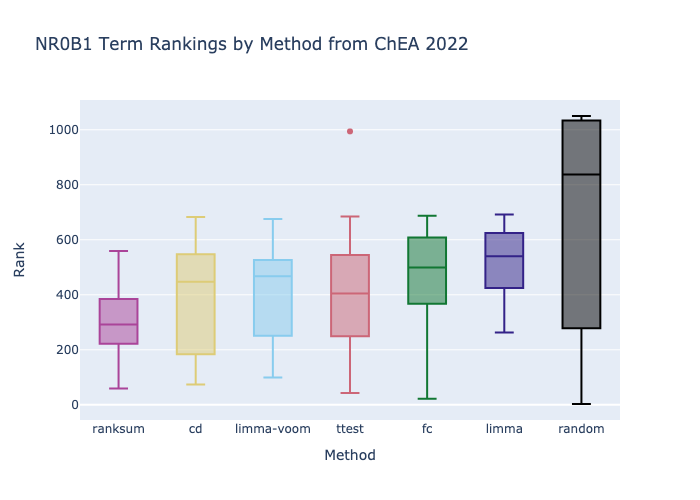

In [47]:
# with ChEA manual libraries
method_color_map = {
    'random': 'black',
    'cd': '#DDCC77',
    'limma': '#332288',
    'limma-voom': '#88CCEE',
    'fc': '#117733',
    'ttest': '#CC6677',
    'ranksum': '#AA4499',
}

for l in full_df['Library'].unique(): 

    sub_df = full_df[full_df['Library']==l].set_index(['Method'])
    fig1 = go.Figure()
    for gs in sub_df.groupby('Method').mean(numeric_only=True).sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df.loc[gs]['Rank'].tolist(),
                name=gs,
                marker_color=method_color_map[gs]
            )
        )
    sub_rand_df = rand_df[rand_df['Library'] == l]
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Method']=='random']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )
    fig1.update_layout(
        title_text=f"{ko_gene} Term Rankings by Method from {l}",
        xaxis={
            'title': {'text': 'Method'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

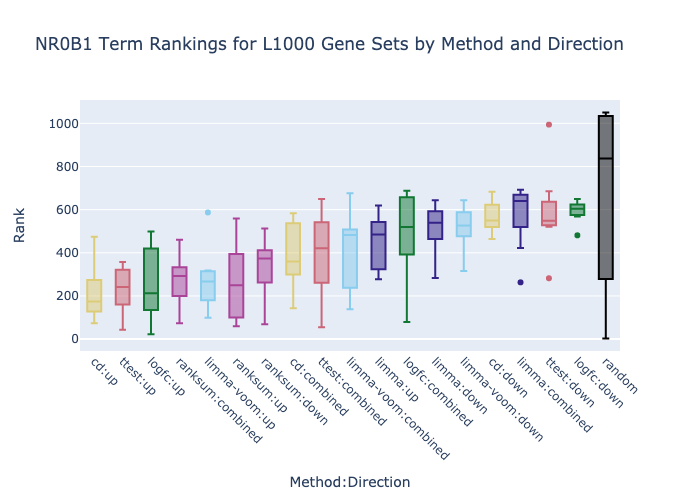

In [49]:
color_dict = {
    'random': 'black',
    'cd': '#DDCC77',
    'limma': '#332288',
    'limma-voom': '#88CCEE',
    'fc': '#117733',
    'ttest': '#CC6677',
    'ranksum': '#AA4499',
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.replace('fc', 'logfc'),
            marker_color=color_dict[gs.split(':')[0]]
        )
    )
fig1.add_trace(
    go.Box(
        y=rand_df[rand_df['Method']==f'random']['Rank'].tolist(),
        name='random',
        marker_color='black'
    )
)
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.update_xaxes(tickangle=45)
fig1.show("png")

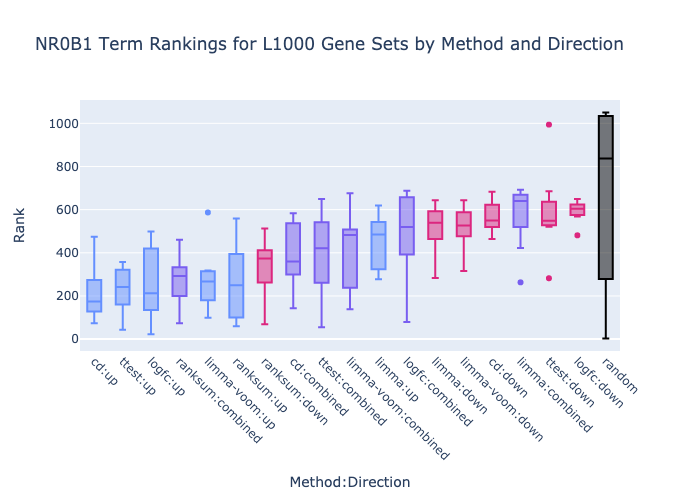

In [55]:
color_dict = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.replace('fc', 'logfc'),
            marker_color=color_dict[gs.split(':')[1]]
        )
    )
fig1.add_trace(
    go.Box(
        y=rand_df[rand_df['Method']==f'random']['Rank'].tolist(),
        name='random',
        marker_color='#000000'
    )
)
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.update_xaxes(tickangle=45)
fig1.show("png")

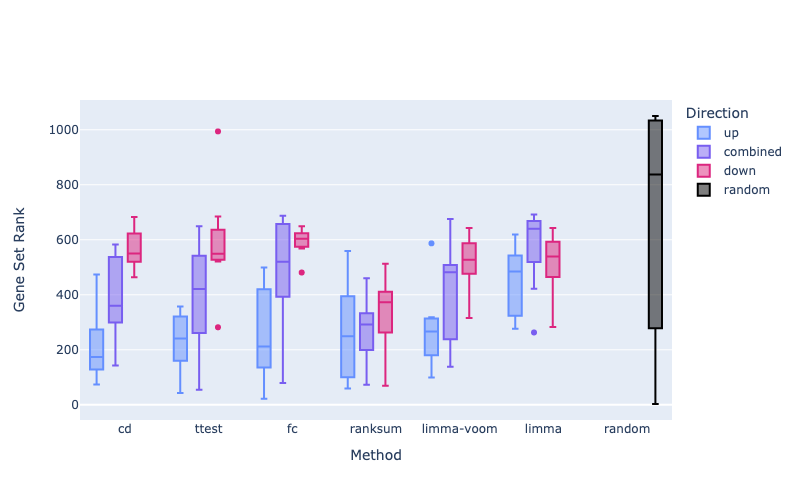

In [56]:
method_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}
fig1 = go.Figure()
order = full_df.groupby(['Method_Direction']).mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x.split(':')[0]).unique()
full_df['Method'] = pd.Categorical(full_df['Method'], order)
full_df = full_df.sort_values(by=['Method'])

for d in ['up', 'combined', 'down']:
  d_df = full_df[full_df['Direction'] == d]
  fig1.add_trace(
    go.Box(
      x=d_df['Method'],
      y=d_df['Rank'],
      name=d, 
      marker_color=method_color_map[d]
    )
  )

fig1.add_trace(
  go.Box(
    x=rand_df['Method'],
    y=rand_df['Rank'],
    name='random',
    marker_color='black'
  )
)

fig1.update_layout(
  width=800,
  boxmode='group',
  boxgap=0.1,
  xaxis={
    'title': {'text': 'Method'},
  },
  yaxis={
    'title': {'text': 'Gene Set Rank'}
  },
  legend_title_text="Direction"
)
fig1.show("png")
fig1.write_image(f'/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/4_{ko_gene}_1_300dpi.png', scale=(800/300))

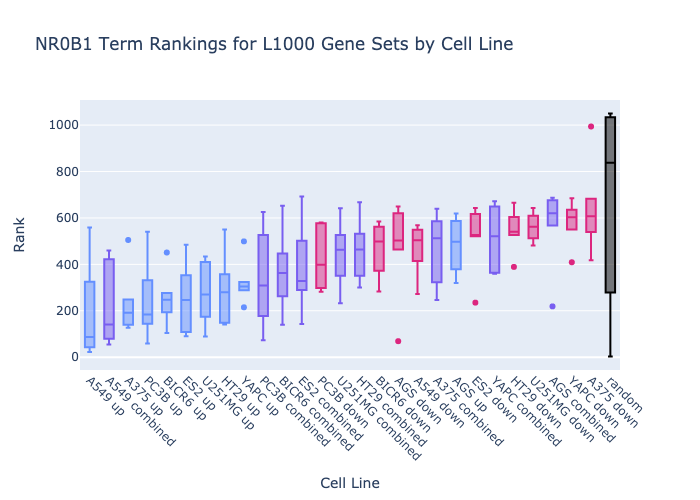

In [57]:
dir_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}

full_df['Batch'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0].split('_')[1].replace('.311',''))
for l in full_df['Library'].unique():
    sub_df = full_df[full_df['Library'] == l].set_index(['Direction', 'Batch'])
    fig1 = go.Figure()
    for (d, b) in sub_df.groupby(['Direction', 'Batch']).mean(numeric_only=True).sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df.loc[(d,b)]['Rank'].tolist(),
                name=b + ' ' + d,
                marker_color=dir_color_map[d]
            )
        )
    sub_rand_df = rand_df[rand_df['Library'] == l]
    fig1.add_trace(
        go.Box(
            y=sub_rand_df[sub_rand_df['Method']==f'random']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )
    fig1.update_layout(
        title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Cell Line",
        xaxis={
            'title': {'text': 'Cell Line'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
)
fig1.update_xaxes(tickangle=45)
fig1.show("png")

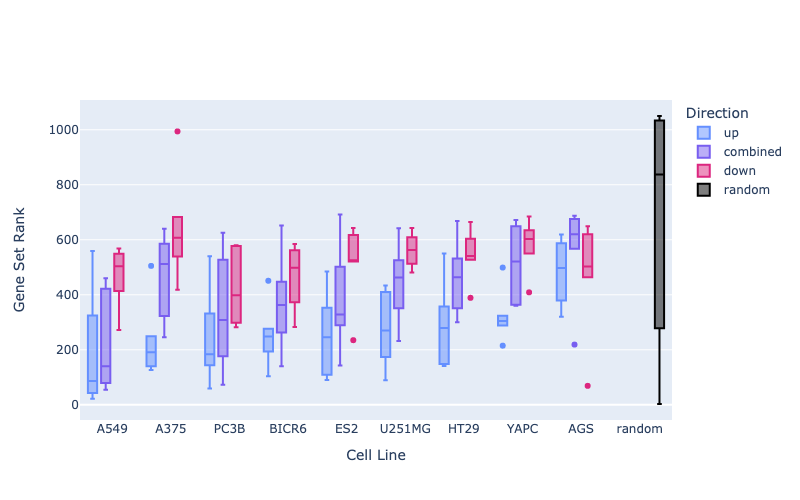

In [58]:
method_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}
fig1 = go.Figure()
order = full_df.groupby(['Direction', 'Cell']).mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x[1].split(':')[0]).unique()
full_df['Cell'] = pd.Categorical(full_df['Cell'], order)
full_df = full_df.sort_values(by=['Cell'])

for d in ['up', 'combined', 'down']:
  d_df = full_df[full_df['Direction'] == d]
  fig1.add_trace(
    go.Box(
      x=d_df['Cell'],
      y=d_df['Rank'],
      name=d, 
      marker_color=method_color_map[d]
    )
  )

fig1.add_trace(
  go.Box(
    x=rand_df['Method'],
    y=rand_df['Rank'],
    name='random',
    marker_color='black'
  )
)

fig1.update_layout(
  width=800,
  boxmode='group',
  boxgap=0.1,
  xaxis={
    'title': {'text': 'Cell Line'},
  },
  yaxis={
    'title': {'text': 'Gene Set Rank'}
  },
  legend_title_text="Direction"
)
fig1.show("png")
fig1.write_image(f'/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/4_{ko_gene}_2_300dpi.png', scale=(800/300))